In [1]:
import numpy as np
import pv_vision.transform_seg.perspective_transform as transform
import matplotlib.pyplot as plt 
from skimage.morphology import skeletonize
from pathlib import Path
import os
import cv2 as cv
import json
from scipy import stats

%matplotlib inline

In [2]:
mask_dir = Path("data/prediction_v3_crack/ann")
img_dir = Path("../../image_segmentation/out/Output_aug/")
mask_anns = os.listdir(mask_dir)

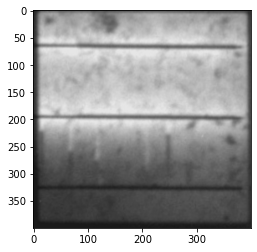

In [3]:
image = cv.imread(str(img_dir/os.path.splitext(mask_anns[0])[0]),cv.IMREAD_UNCHANGED)
plt.imshow(image, "gray")

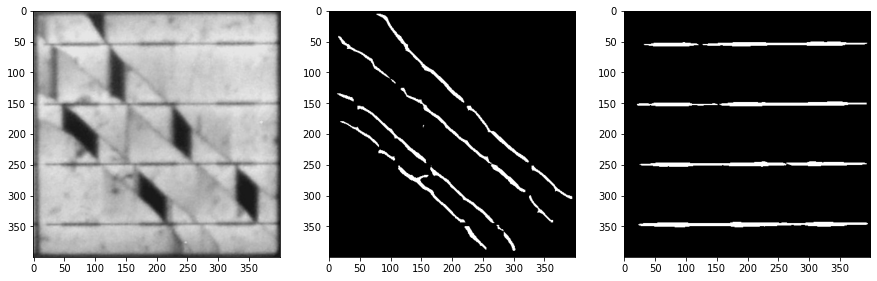

In [4]:
mask_ann = mask_anns[60]
image = cv.imread(str(img_dir/os.path.splitext(mask_ann)[0]),cv.IMREAD_UNCHANGED)

mask_crack, _ = transform.load_mask(mask_dir/mask_ann, image, "crack_b_unet")
mask_busbar, _ = transform.load_mask(mask_dir/mask_ann, image, "busbar_b_unet")

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image, "gray")

plt.subplot(132)
plt.imshow(mask_crack, "gray")

plt.subplot(133)
plt.imshow(mask_busbar, "gray")

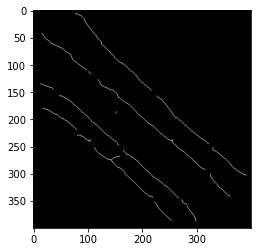

In [5]:
ske_crack = skeletonize(mask_crack).astype(np.uint8)
plt.imshow(ske_crack, "gray")

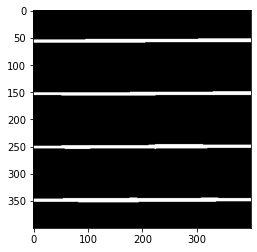

In [6]:
kernel = np.ones((10,100), np.uint8)
closing = cv.morphologyEx(mask_busbar, cv.MORPH_CLOSE, kernel)
plt.imshow(closing, "gray")

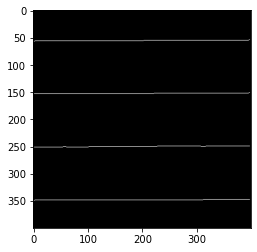

In [7]:
ske_busbar = skeletonize(closing).astype(np.uint8)
plt.imshow(ske_busbar, "gray")

In [8]:
numList_busbar = []
for i in np.linspace(10, mask_busbar.shape[-1]-10, 10, dtype=int):
    numList_busbar.append(len(np.argwhere(ske_busbar[:, i]==1)))

num_busbar = stats.mode(numList_busbar).mode[0]

pos_busbar = np.zeros((num_busbar, 1))
for i in np.linspace(10, mask_busbar.shape[-1]-10, 100, dtype=int):
    tem_pos = np.argwhere(ske_busbar[:, i]==1)
    
    if len(tem_pos) == num_busbar:
        pos_busbar = np.hstack((pos_busbar, tem_pos))

pos_busbar = np.delete(pos_busbar, 0, axis=1)
pos_busbar = pos_busbar.mean(axis=1, dtype=int).tolist()

In [9]:
pos_busbar

[55, 152, 249, 347]

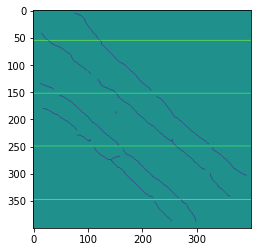

In [10]:
ske_cell = ske_crack * -1
for i in pos_busbar:
    ske_cell[i, :] = 1

plt.imshow(ske_cell)

In [11]:
def stop_diff(val):
   return (val == 1 or val == -1)


In [34]:
def diff_up(image, row, col):
    current = row - 1
    while not (current < 0 or stop_diff(image[current, col])):
        image[current, col] = 1
        current -= 1

In [43]:
def diff_down(image, row, col):
    end = image.shape[0]
    current = row + 1
    while not (current > end - 1 or stop_diff(image[current, col])):
        image[current, col] = 1
        current += 1

In [40]:
def diffuse_line(image, row):
    for j in range(image.shape[-1]):
        diff_up(image, row, j)
        diff_down(image, row, j)

In [41]:
def diffuse(image, pos_busbar):
    image_c = np.copy(image)
    for i in pos_busbar:
        diffuse_line(image_c, i)
    return image_c
    

In [44]:
cell_diff = diffuse(ske_cell, pos_busbar)

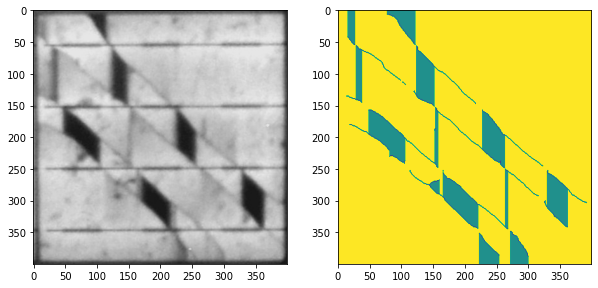

In [47]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(image, "gray")

plt.subplot(122)
plt.imshow(cell_diff)

In [57]:
inactive_area = np.zeros(cell_diff.shape).astype(np.uint8)
inactive_area[cell_diff==0] = 1


In [62]:
inactive_area.sum() / (inactive_area.shape[0] * inactive_area.shape[1])

0.1023

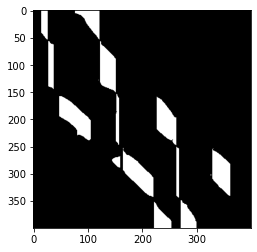

In [60]:
plt.imshow(inactive_area, "gray")